In [19]:
# Intel Processor Data - Exploratory Data Analysis (EDA)
# Import all necessary libraries
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set pandas display options
pd.set_option('display.max_columns', 120)

# Point to your file
PATH = "../data/intel_processors_master.json"

# Verify file exists
if not Path(PATH).exists():
    print(f"Warning: {PATH} not found. Please ensure the data file exists.")
else:
    print(f"Data file found: {PATH}")

Data file found: ../data/intel_processors_master.json


In [20]:
# Load the JSON data
try:
    with open(PATH, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    raw = data["processors"]  # list of dicts
    
    # Flatten nested dicts into columns like: essentials.product_collection, cpu_specifications.total_cores, ...
    df = pd.json_normalize(raw, sep=".")
    
    print(f"Successfully loaded {len(df)} processors")
    print(f"Data shape: {df.shape}")
    print(f"First 12 columns: {list(df.columns[:12])}")
    
except FileNotFoundError:
    print(f"Error: Could not find file {PATH}")
    print("Please ensure the data file exists in the correct location.")
except json.JSONDecodeError as e:
    print(f"Error: Invalid JSON format in {PATH}")
    print(f"JSON error: {e}")
except Exception as e:
    print(f"Unexpected error loading data: {e}")

Successfully loaded 148 processors
Data shape: (148, 181)
First 12 columns: ['processor_name', 'category', 'file_source', 'essentials.product_collection', 'essentials.code_name', 'essentials.vertical_segment', 'essentials.processor_number', 'essentials.lithography', 'essentials.recommended_customer_price', 'cpu_specifications.total_cores', 'cpu_specifications.num_of_performancecores', 'cpu_specifications.num_of_efficientcores']


In [21]:
# rows/cols
print("Shape:", df.shape)

# columns by section
sections = sorted(set(c.split(".")[0] for c in df.columns if "." in c))
print("Top-level sections:", sections)

# basic counts per category / code name
print(df["category"].value_counts(dropna=False).head(10))
if "essentials.code_name" in df.columns:
    print(df["essentials.code_name"].value_counts(dropna=False).head(10))

# missingness summary (top 30)
missing = df.isna().mean().sort_values(ascending=False)
missing.head(30)

Shape: (148, 181)
Top-level sections: ['advanced_technologies', 'cpu_specifications', 'essentials', 'expansion_options', 'memory_specifications', 'package_specifications', 'supplemental_information']
category
Xeon_Processors          68
Core_Ultra_Processors    44
Core_Processors          31
Xeon_Max_Processors       5
Name: count, dtype: int64
essentials.code_name
Products formerly Granite Rapids         40
Products formerly Arrow Lake             35
Products formerly Raptor Lake            29
Products formerly Granite Rapids-D       13
Products formerly Bartlett Lake          10
Products formerly Lunar Lake              9
Products formerly Sierra Forest           7
Products formerly Sapphire Rapids HBM     5
Name: count, dtype: int64


memory_specifications.integrated_lan                                             0.986486
cpu_specifications.priority_core_turbo_pct_technology__max_pct_core_frequency    0.986486
advanced_technologies.intel_media_transcode_accelerator                          0.986486
cpu_specifications.priority_core_turbo_pct_technology__max_pct_cores             0.986486
memory_specifications.maximum_high_bandwidth_memory_hbm                          0.966216
cpu_specifications.intel_turbo_boost_technology_20_frequency                     0.945946
memory_specifications.intel_clear_video_hd_technology                            0.939189
advanced_technologies.intel_partner_security_engine_                             0.939189
memory_specifications.h266_vvc_hardware_encodedecode                             0.939189
advanced_technologies.intel_adaptive_boost_technology                            0.932432
cpu_specifications.maximum_assured_power                                         0.932432
expansion_

In [22]:
def first_number(s):
    if pd.isna(s): return np.nan
    m = re.search(r"[\d.]+", str(s).replace(",", ""))
    return float(m.group()) if m else np.nan

def to_ghz(s):
    if pd.isna(s): return np.nan
    s = str(s).lower()
    x = first_number(s)
    if x is np.nan: return np.nan
    if "mhz" in s:  # Convert MHz to GHz
        return x / 1000.0
    elif "ghz" in s:  # Explicitly handle GHz
        return x
    return x  # Assume already GHz if no unit specified

def to_int(s):
    x = first_number(s)
    return int(round(x)) if not np.isnan(x) else np.nan

def to_float(s):
    x = first_number(s)
    return float(x) if not np.isnan(x) else np.nan


In [23]:
# start from a copy so original flat df is preserved
clean = df.copy()

# columns we will derive (create if missing)
def safe_get(col): 
    return clean[col] if col in clean.columns else np.nan

# CPU
clean["feat.total_cores"]   = pd.to_numeric(safe_get("cpu_specifications.total_cores"), errors="coerce")
clean["feat.total_threads"] = pd.to_numeric(safe_get("cpu_specifications.total_threads"), errors="coerce")

clean["feat.max_turbo_ghz"] = safe_get("cpu_specifications.max_turbo_frequency").apply(to_ghz)
# some rows have per-core turbo only; use whichever exists
if clean["feat.max_turbo_ghz"].isna().all() and "cpu_specifications.performancecore_max_turbo_frequency" in clean.columns:
    clean["feat.max_turbo_ghz"] = clean["cpu_specifications.performancecore_max_turbo_frequency"].apply(to_ghz)

# CRITICAL ADDITION: Base frequency (guaranteed minimum performance)
clean["feat.base_freq_ghz"] = safe_get("cpu_specifications.processor_base_frequency").apply(to_ghz)

# Cache (MB)
clean["feat.cache_mb"] = safe_get("cpu_specifications.cache").apply(to_float)  # often "10 MB ..." -> 10

# Power (W)
clean["feat.base_power_w"]  = safe_get("cpu_specifications.processor_base_power").apply(to_float)
clean["feat.turbo_power_w"] = safe_get("cpu_specifications.maximum_turbo_power").apply(to_float)

# CRITICAL ADDITION: Price (essential for recommendations)
clean["feat.price_usd"] = safe_get("essentials.recommended_customer_price").apply(to_float)

# Memory (GB)
clean["feat.max_mem_gb"] = safe_get("memory_specifications.max_memory_size_dependent_on_memory_type").apply(to_float)

# iGPU (if present)
clean["feat.gfx_max_dyn_ghz"] = safe_get("memory_specifications.graphics_max_dynamic_frequency").apply(to_ghz)
clean["feat.execution_units"] = pd.to_numeric(safe_get("memory_specifications.execution_units"), errors="coerce")

# CRITICAL ADDITION: Use case segmentation
clean["feat.vertical_segment"] = safe_get("essentials.vertical_segment")

# DERIVED FEATURES: Performance ratios (very useful for recommendations)
clean["feat.freq_per_watt"] = clean["feat.max_turbo_ghz"] / clean["feat.base_power_w"]
clean["feat.cores_per_watt"] = clean["feat.total_cores"] / clean["feat.base_power_w"]
clean["feat.cache_per_core"] = clean["feat.cache_mb"] / clean["feat.total_cores"]

# Minimal ID columns
id_cols = ["processor_name", "category", "essentials.product_collection", "essentials.code_name", "essentials.vertical_segment"]
for c in id_cols:
    if c not in clean.columns: clean[c] = np.nan

# Keep a tidy view
feature_cols = [c for c in clean.columns if c.startswith("feat.")]
features = clean[["processor_name", "category"] + feature_cols].copy()
features.head()

,processor_name,category,feat.total_cores,feat.total_threads,feat.max_turbo_ghz,feat.base_freq_ghz,feat.cache_mb,feat.base_power_w,feat.turbo_power_w,feat.price_usd,feat.max_mem_gb,feat.gfx_max_dyn_ghz,feat.execution_units,feat.vertical_segment,feat.freq_per_watt,feat.cores_per_watt,feat.cache_per_core
0,Intel® Core™ 3 processor 100HL (12M Cache- up ...,Core_Processors,8,12,4.6,2.1,12.0,45.0,115.0,306.0,96.0,1.30,48.0,Embedded,0.102222,0.177778,1.500000
1,Intel® Core™ 3 processor 100UL (10M Cache- up ...,Core_Processors,6,8,4.5,NaN,10.0,15.0,55.0,285.0,96.0,1.25,64.0,Embedded,0.300000,0.400000,1.666667
2,Intel® Core™ 3 processor 100U (10M Cache- up t...,Core_Processors,6,8,4.7,NaN,10.0,15.0,55.0,NaN,96.0,1.25,64.0,Mobile,0.313333,0.400000,1.666667
3,Intel® Core™ 3 processor 100U (10M Cache- up t...,Core_Processors,6,8,4.7,NaN,10.0,15.0,55.0,NaN,96.0,1.25,64.0,Mobile,0.313333,0.400000,1.666667
4,Intel® Core™ 3 Processor 201EF (12M Cache- up ...,Core_Processors,4,8,4.8,NaN,12.0,NaN,NaN,NaN,192.0,NaN,NaN,Embedded,NaN,NaN,3.000000


In [24]:
# Handle missing values more intelligently
numeric_feature_cols = [c for c in feature_cols if c != "feat.vertical_segment"]

# Simple imputation: median for numeric features
for c in numeric_feature_cols:
    med = features[c].median(skipna=True)
    features[c] = features[c].fillna(med)

# Handle categorical feature (vertical_segment)
if "feat.vertical_segment" in features.columns:
    # Fill missing vertical segments with most common value
    mode_segment = features["feat.vertical_segment"].mode()
    if len(mode_segment) > 0:
        features["feat.vertical_segment"] = features["feat.vertical_segment"].fillna(mode_segment[0])
    else:
        features["feat.vertical_segment"] = features["feat.vertical_segment"].fillna("Unknown")

# Drop rows that are still too empty (unlikely after median fill)
features = features.dropna(subset=numeric_feature_cols, how="any")

# Sanity: no negatives for numeric features, reasonable ranges
assert (features[numeric_feature_cols] >= 0).all().all()

# Display summary statistics
print("Dataset shape after cleaning:", features.shape)
print("\nFeature summary:")
features.describe().T

Dataset shape after cleaning: (148, 17)

Feature summary:


,count,mean,std,min,25%,50%,75%,max
feat.total_cores,148.0,30.486486,31.397059,4.0000,10.000000,16.000000,36.000000,144.00
feat.total_threads,148.0,50.027027,54.763803,4.0000,14.000000,20.000000,72.000000,256.00
feat.max_turbo_ghz,148.0,4.503378,0.740970,2.6000,3.900000,4.700000,5.100000,5.80
feat.base_freq_ghz,148.0,2.453378,0.361481,1.8000,2.400000,2.400000,2.400000,4.00
feat.cache_mb,148.0,99.912162,127.837811,8.0000,18.000000,30.000000,144.000000,504.00
feat.base_power_w,148.0,38.195946,20.102005,15.0000,35.000000,35.000000,35.000000,125.00
feat.turbo_power_w,148.0,110.648649,35.971619,37.0000,115.000000,115.000000,115.000000,250.00
feat.price_usd,148.0,2474.871622,3422.481807,134.0000,429.000000,1195.000000,2619.000000,19000.00
feat.max_mem_gb,148.0,89.234392,96.647394,1.1300,4.000000,64.000000,128.000000,256.00
feat.gfx_max_dyn_ghz,148.0,1.803446,0.214925,1.2500,1.850000,1.850000,1.850000,2.35


In [25]:
# Flat, all columns (good for EDA)
df.to_csv("../data/intel_processors_flat.csv", index=False)
df.to_parquet("../data/intel_processors_flat.parquet", index=False)

# Clean numeric features (good for k-NN / cosine)
features.to_csv("../data/intel_processors_features.csv", index=False)
features.to_parquet("../data/intel_processors_features.parquet", index=False)

# (Optional) cleaned JSON Lines if you want JSON too
df.to_json("../data/intel_processors_flat.jsonl", orient="records", lines=True, force_ascii=False)

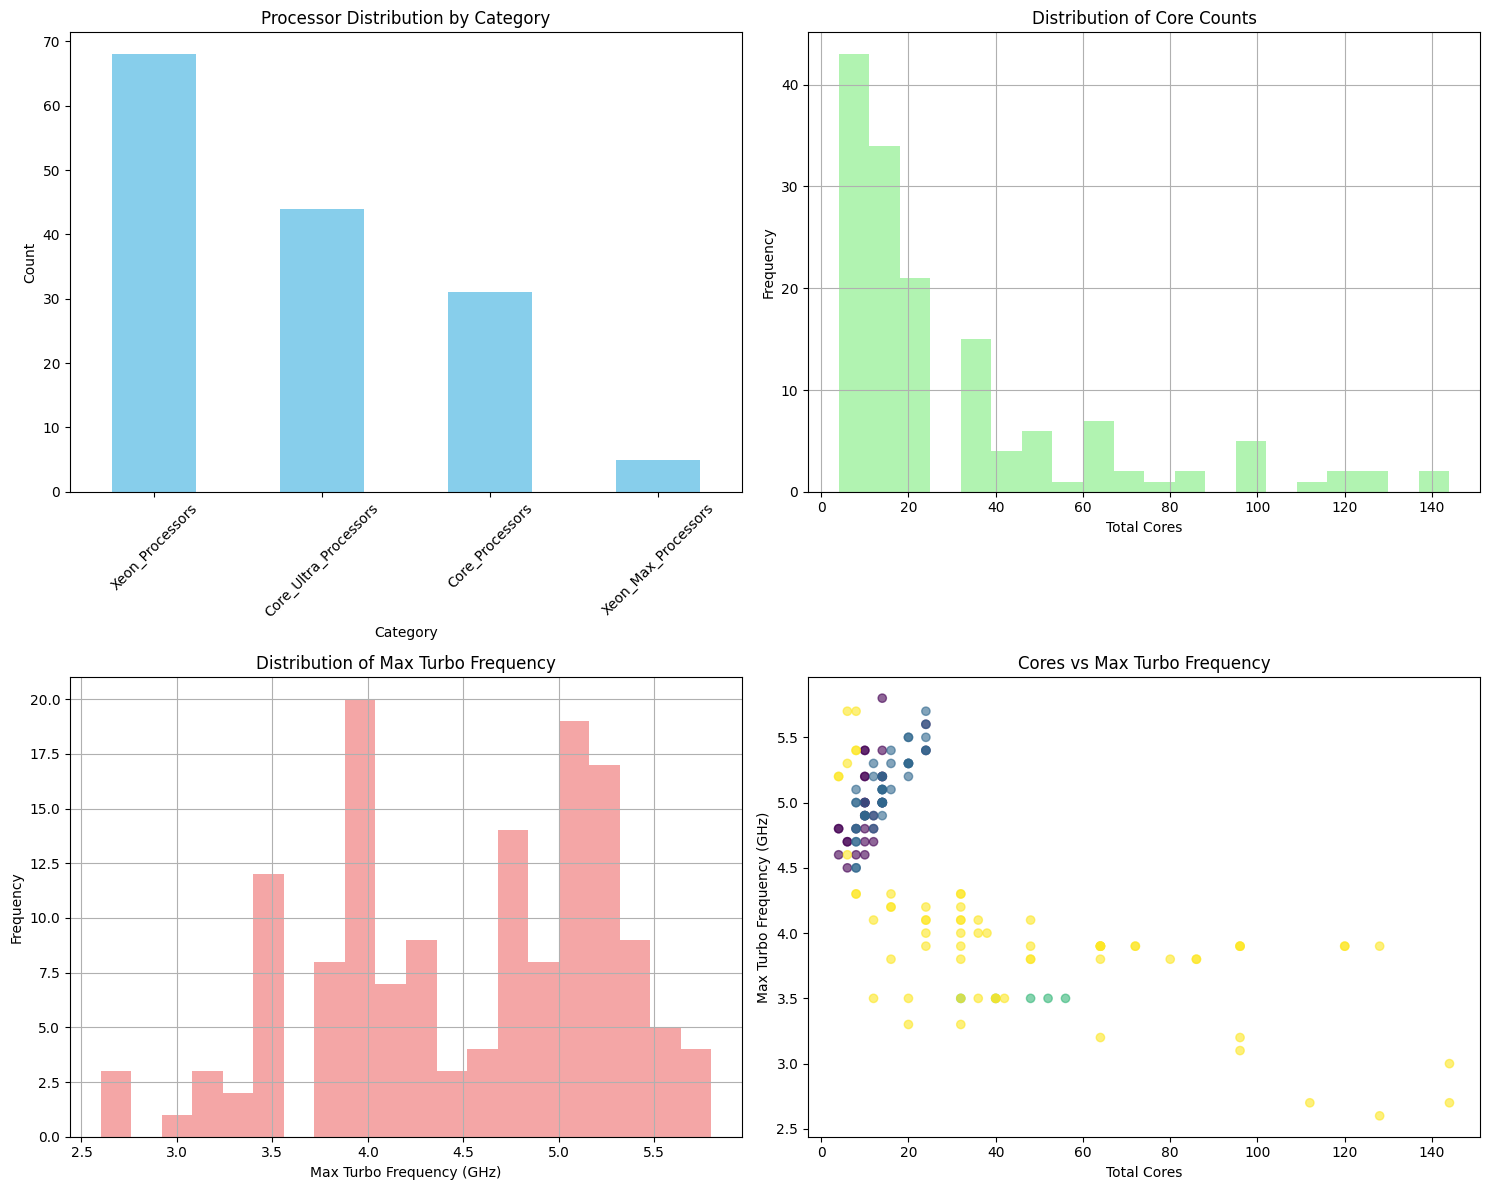

✅ EDA visualizations completed!


In [26]:
# Basic Visualizations for EDA
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Processor distribution by category
features['category'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Processor Distribution by Category')
axes[0, 0].set_xlabel('Category')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Core count distribution
features['feat.total_cores'].hist(bins=20, ax=axes[0, 1], color='lightgreen', alpha=0.7)
axes[0, 1].set_title('Distribution of Core Counts')
axes[0, 1].set_xlabel('Total Cores')
axes[0, 1].set_ylabel('Frequency')

# 3. Max turbo frequency distribution
features['feat.max_turbo_ghz'].hist(bins=20, ax=axes[1, 0], color='lightcoral', alpha=0.7)
axes[1, 0].set_title('Distribution of Max Turbo Frequency')
axes[1, 0].set_xlabel('Max Turbo Frequency (GHz)')
axes[1, 0].set_ylabel('Frequency')

# 4. Cores vs Frequency scatter plot
scatter = axes[1, 1].scatter(features['feat.total_cores'], features['feat.max_turbo_ghz'], 
                           c=features['category'].astype('category').cat.codes, alpha=0.6)
axes[1, 1].set_title('Cores vs Max Turbo Frequency')
axes[1, 1].set_xlabel('Total Cores')
axes[1, 1].set_ylabel('Max Turbo Frequency (GHz)')

plt.tight_layout()
plt.show()

print("✅ EDA visualizations completed!")

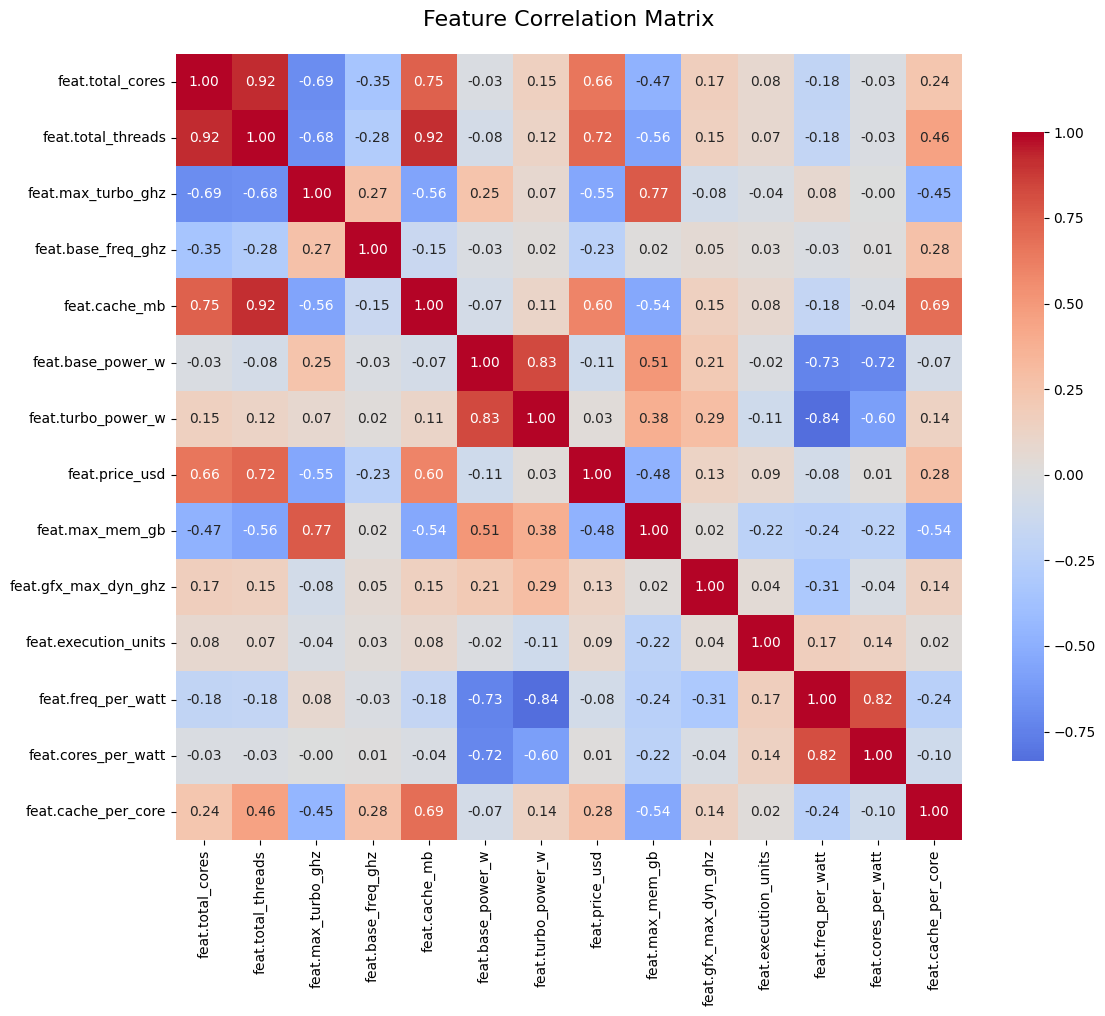

✅ Correlation analysis completed!
Total numeric features analyzed: 14
Most correlated feature pairs:
  1. feat.total_cores ↔ feat.total_threads: 0.923
  2. feat.total_threads ↔ feat.cache_mb: 0.919
  3. feat.turbo_power_w ↔ feat.freq_per_watt: 0.837
  4. feat.base_power_w ↔ feat.turbo_power_w: 0.828
  5. feat.freq_per_watt ↔ feat.cores_per_watt: 0.819


In [27]:
# Correlation Analysis
plt.figure(figsize=(12, 10))

# Select numeric features for correlation analysis
numeric_features = features.select_dtypes(include=[np.number]).columns
correlation_matrix = features[numeric_features].corr()

# Create heatmap
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'shrink': .8})

plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

print("✅ Correlation analysis completed!")
print(f"Total numeric features analyzed: {len(numeric_features)}")
print(f"Most correlated feature pairs:")
# Find highest correlations (excluding diagonal)
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if not np.isnan(corr_val):
            corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], abs(corr_val)))

# Sort by absolute correlation value
corr_pairs.sort(key=lambda x: x[2], reverse=True)
for i, (feat1, feat2, corr_val) in enumerate(corr_pairs[:5]):
    print(f"  {i+1}. {feat1} ↔ {feat2}: {corr_val:.3f}")